In [1]:
import numpy as np
import GPy
import scipy.io
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,roc_curve
from sklearn.metrics import precision_recall_curve,auc,average_precision_score
import pandas as pd


if __name__ == "__main__":
    mat = scipy.io.loadmat('Datos.mat')
    healthy = mat['Healthy_folds'][0]
    malign = mat['Malign_folds'][0]
    print(malign[4][0].shape)
    print(malign[3][0].shape)
    print(healthy[4][0].shape)
    print(healthy.shape)
    print(len(healthy))

(69, 10)
(50, 10)
(199, 10)
(5,)
5


In [2]:
# Función para crear el conjunto de training.
def createTrainingSet(healthy_set,malign_set,index):
    healthy_list = [healthy_set[ind][0] for ind in range(len(healthy_set)) if ind != index]
    malign_list = [malign_set[ind][0] for ind in range(len(malign_set)) if ind != index]
    
    trainSet = np.array(healthy_list[0])
    trainLabels = np.ones(healthy_list[0].shape[0])*(-1)
    trainSet = np.append(trainSet,malign_list[0],axis=0)
    trainLabels = np.append(trainLabels,np.ones(malign_list[0].shape[0]))
   
    for ind in range(1,len(healthy_list)):
        trainSet = np.append(trainSet,healthy_list[ind],axis=0)
        trainLabels = np.append(trainLabels,np.ones(healthy_list[ind].shape[0])*(-1))
        trainSet = np.append(trainSet,malign_list[ind],axis=0)
        trainLabels = np.append(trainLabels,np.ones(malign_list[ind].shape[0]))
    
    
    trainLabels = np.mat(trainLabels,dtype=int)
    
    return trainSet,trainLabels


# Función para crear el conjunto de test.
def createTestSet(healthy_set,malign_set,index):
    testSet = np.append(healthy_set[index][0],
                       malign_set[index][0],
                       axis=0)
    h_shape = healthy_set[index][0].shape[0]
    m_shape = malign_set[index][0].shape[0]
    testLabels = np.append(np.ones(h_shape)*(-1),np.ones(m_shape))
    testLabels = np.mat(testLabels,dtype=int)
    
    return testSet,testLabels


testData,testLabels = createTestSet(healthy,malign,index=4)
trainData,trainLabels =  createTrainingSet(healthy,malign,4)
print(testLabels.shape)

(1, 268)


In [3]:
def getLabelsPredicted(probs_predicted,theta=0.5):
    labels = np.array([int(value >= theta) for value in probs_predicted])
    return labels

def toLabelArray(labelMat):
    label_arr = np.array(labelMat).reshape((-1,))
    label_arr[label_arr == -1] = 0
    return label_arr

In [4]:
def calculateMetrics(y_real,y_pred):
    tn,fp,fn,tp = confusion_matrix(y_real,y_pred).ravel()
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    precision = tp/(tp+fp)
    specificity = tn/(tn+fp)
    recall = tp/(tp+fn)
    f1_score = (2*precision*recall)/(precision+recall)
    
    return dict(acc=accuracy,precision=precision,
               specificity=specificity,recall=recall,
               f1score=f1_score)

In [5]:
def calculateProbs(models,test_data):
    probs = np.array([m.predict(test_data)[0].reshape((-1,)) for m in models])
    real_probs = np.mean(probs,axis=0)
    return real_probs

In [6]:
def plotRocCurve(y_real,y_probs,savename=None):
    fpr, tpr, thresholds = roc_curve(y_real,y_probs)
    
    # plot the roc curve for the model
    plt.plot(fpr, tpr, marker='.')
    # plot no skill
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("ROC Curve")
    
    auc = roc_auc_score(y_real,y_probs)
    print('AUC: %.3f' % auc)
    plt.legend(['AUC: %.3f' % auc])
    
    try:
        plt.savefig(savename)
    except:
        pass
    
    # show the plot
    plt.show()

In [7]:
def plotPrecisionRecallCurve(y_real,y_probs,savename=None):
    # calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_real, y_probs)
    yhat = getLabelsPredicted(y_probs)
    
    # calculate F1 score
    f1 = f1_score(y_real, yhat)
    # calculate precision-recall AUC
    auc_m = auc(recall, precision)
    # calculate average precision score
    ap = average_precision_score(y_real, y_probs)
    print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_m, ap))
    
    # plot the roc curve for the model
    plt.plot(recall, precision, marker='.')
    # plot no skill
    plt.plot([0, 1], [0.5, 0.5], linestyle='--')
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.title("Precision-Recall Curve")
    plt.legend(['AUC: %.3f' % auc_m])
    try:
        plt.savefig(savename)
    except:
        pass
    
    # show the plot
    plt.show()

In [8]:
def plotConfusionMatrix(y_true,y_pred,savename=None):
    confusion_mat = confusion_matrix(y_true,y_pred)
    df_mat = pd.DataFrame(confusion_mat,columns=["healthy","cancerous"],index=["healthy","cancerous"])

    fig = sns.heatmap(df_mat,annot=True,fmt="d",cbar=False)
    fig.set(title="confusion matrix",xlabel="predicted labels",ylabel="true labels")
    try:
        figure = fig.get_figure()    
        figure.savefig(savename)
    except:
        pass

In [9]:
trainData,trainLabels = createTrainingSet(healthy,malign,0)
ker = GPy.kern.Linear(10)
lik = GPy.likelihoods.Bernoulli()
m1_linear = GPy.models.gp_var_gauss.GPVariationalGaussianApproximation(trainData,trainLabels.T,kernel=ker,likelihood=lik)
# Optimizamos el modelo.
m1_linear.optimize()

 C:\Users\Alberto Armijo Ruiz\Anaconda3\envs\neuralnets\lib\site-packages\GPy\likelihoods\bernoulli.py:107: RuntimeWarning:invalid value encountered in sqrt


In [10]:
# Preparamos los modelos de procesos gaussianos.
trainData,trainLabels = createTrainingSet(healthy,malign,1)
ker = GPy.kern.Linear(10)
lik = GPy.likelihoods.Bernoulli()
m2_linear = GPy.models.gp_var_gauss.GPVariationalGaussianApproximation(trainData,trainLabels.T,kernel=ker,likelihood=lik)
# Optimizamos el modelo.
m2_linear.optimize()

In [11]:
# Preparamos los modelos de procesos gaussianos.
trainData,trainLabels = createTrainingSet(healthy,malign,2)
ker = GPy.kern.Linear(10)
lik = GPy.likelihoods.Bernoulli()
m3_linear = GPy.models.gp_var_gauss.GPVariationalGaussianApproximation(trainData,trainLabels.T,kernel=ker,likelihood=lik)
# Optimizamos el modelo.
m3_linear.optimize()

In [12]:
# Preparamos los modelos de procesos gaussianos.
trainData,trainLabels = createTrainingSet(healthy,malign,3)
ker = GPy.kern.Linear(10)
lik = GPy.likelihoods.Bernoulli()
m4_linear = GPy.models.gp_var_gauss.GPVariationalGaussianApproximation(trainData,trainLabels.T,kernel=ker,likelihood=lik)
# Optimizamos el modelo.
m4_linear.optimize()

In [13]:
# Preparamos los modelos de procesos gaussianos.
trainData,trainLabels = createTrainingSet(healthy,malign,4)
ker = GPy.kern.Linear(10)
lik = GPy.likelihoods.Bernoulli()
m5_linear = GPy.models.gp_var_gauss.GPVariationalGaussianApproximation(trainData,trainLabels.T,kernel=ker,likelihood=lik)
# Optimizamos el modelo.
m5_linear.optimize()

In [14]:
t1,l1 = createTestSet(healthy,malign,0)
t2,l2 = createTestSet(healthy,malign,1)
t3,l3 = createTestSet(healthy,malign,2)
t4,l4 = createTestSet(healthy,malign,3)
t5,l5 = createTestSet(healthy,malign,4)
test_data = [t1,t2,t3,t4,t5]
mod = [m1_linear,m2_linear,m3_linear,m4_linear,m5_linear]

In [15]:
# Obtenemos las probabilidades para cada uno de los conjuntos de test
linear_mod = [m1_linear,m2_linear,m3_linear,m4_linear,m5_linear]
probabilities_linear = [calculateProbs(mod,data) for data in test_data ]

In [16]:
labels = [l1,l2,l3,l4,l5]
dataframe = pd.DataFrame(columns=list(calculateMetrics(toLabelArray(l1),getLabelsPredicted(probabilities_linear[0])).keys()))
for ind in range(len(labels)):
    dataframe.loc[ind] = calculateMetrics(toLabelArray(labels[ind]),
                                         getLabelsPredicted(probabilities_linear[ind]))

print(dataframe)

        acc  precision  specificity    recall   f1score
0  0.914397   0.900000     0.980296  0.666667  0.765957
1  0.847518   0.649485     0.838095  0.875000  0.745562
2  0.899614   0.965517     0.995146  0.528302  0.682927
3  0.906504   0.829268     0.964286  0.680000  0.747253
4  0.929104   0.931034     0.979899  0.782609  0.850394


AUC: 0.971


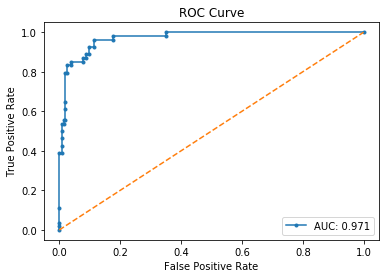

AUC: 0.957


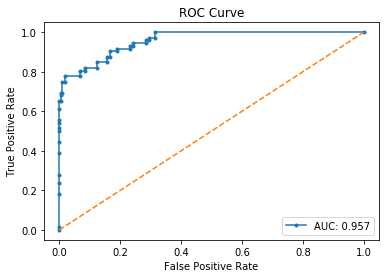

AUC: 0.964


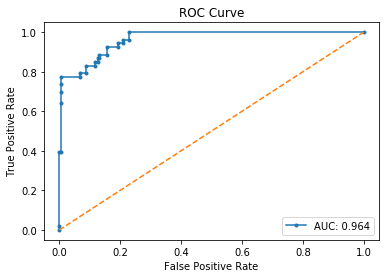

AUC: 0.945


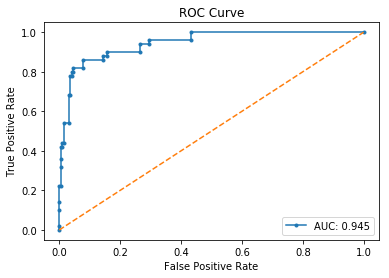

AUC: 0.954


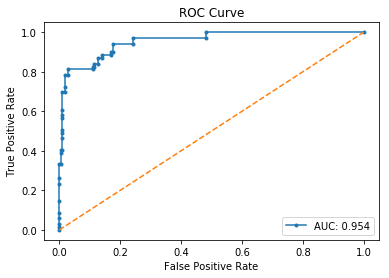

In [17]:
plotRocCurve(toLabelArray(l1),probabilities_linear[0],"./images/p1-roc-linear.pdf")
plotRocCurve(toLabelArray(l2),probabilities_linear[1],"./images/p2-roc-linear.pdf")
plotRocCurve(toLabelArray(l3),probabilities_linear[2],"./images/p3-roc-linear.pdf")
plotRocCurve(toLabelArray(l4),probabilities_linear[3],"./images/p4-roc-linear.pdf")
plotRocCurve(toLabelArray(l5),probabilities_linear[4],"./images/p5-roc-linear.pdf")

f1=0.766 auc=0.907 ap=0.908


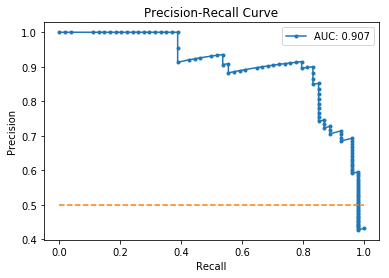

f1=0.746 auc=0.915 ap=0.916


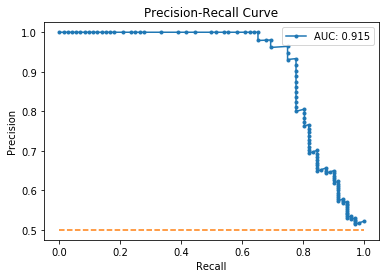

f1=0.683 auc=0.901 ap=0.902


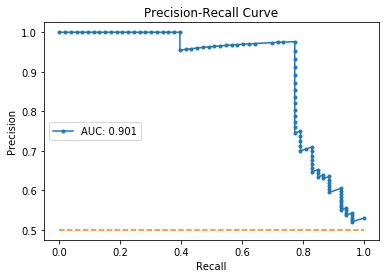

f1=0.747 auc=0.845 ap=0.847


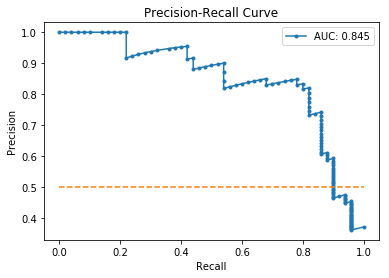

f1=0.850 auc=0.902 ap=0.903


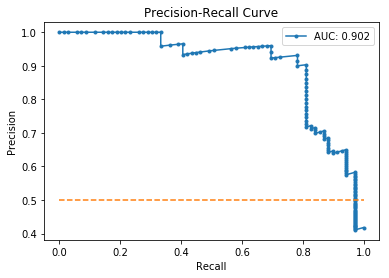

In [18]:
plotPrecisionRecallCurve(toLabelArray(l1),probabilities_linear[0],"./images/p1-curve-linear.pdf")
plotPrecisionRecallCurve(toLabelArray(l2),probabilities_linear[1],"./images/p2-curve-linear.pdf")
plotPrecisionRecallCurve(toLabelArray(l3),probabilities_linear[2],"./images/p3-curve-linear.pdf")
plotPrecisionRecallCurve(toLabelArray(l4),probabilities_linear[3],"./images/p4-curve-linear.pdf")
plotPrecisionRecallCurve(toLabelArray(l5),probabilities_linear[4],"./images/p5-curve-linear.pdf")

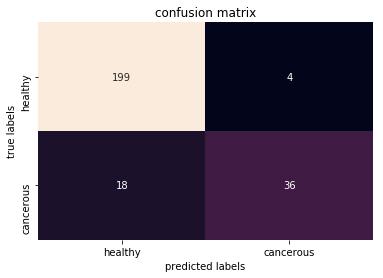

In [19]:
plotConfusionMatrix(toLabelArray(l1),
                   getLabelsPredicted(probabilities_linear[0]),
                   "./images/confusion_mat1_linear.pdf")

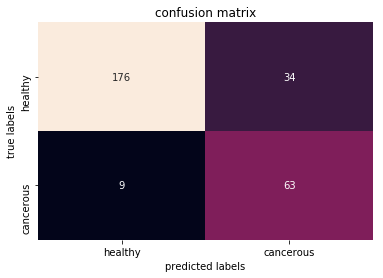

In [20]:
plotConfusionMatrix(toLabelArray(l2),
                   getLabelsPredicted(probabilities_linear[1]),
                   "./images/confusion_mat2_linear.pdf")

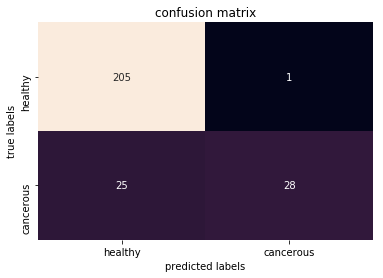

In [21]:
plotConfusionMatrix(toLabelArray(l3),
                   getLabelsPredicted(probabilities_linear[2]),
                   "./images/confusion_mat3_linear.pdf")

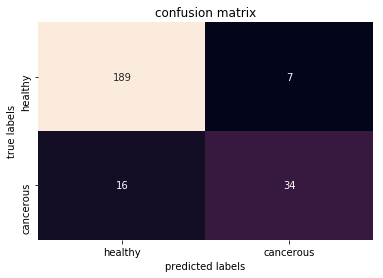

In [22]:
plotConfusionMatrix(toLabelArray(l4),
                   getLabelsPredicted(probabilities_linear[3]),
                   "./images/confusion_mat4_linear.pdf")

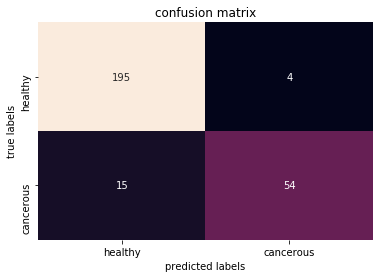

In [23]:
plotConfusionMatrix(toLabelArray(l5),
                   getLabelsPredicted(probabilities_linear[4]),
                   "./images/confusion_mat5_linear.pdf")